# 1. Setup

In [13]:
from lightgbm import LGBMRegressor, plot_tree
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

from utils import *

## 2.1. Load data

In [14]:
trips = pd.read_parquet('../data/trips2.parquet').disp()

727,167 rows x 8 cols; Memory: 20.1 MiB


,Duration,Distance,Speed,Mode,Purpose,StayTime,MSAKind,FlowType
,<float64>,<float64>,<float64>,<category>,<category>,<category>,<category>,<category>
0,16.182075,8.439379,31.291583,Drive,Social,Mid,Small,S → S


# Factor combinations

## Impedance curves histogram data

In [3]:
def get_factor_comb_hist(data=trips, max_vals=D(Distance=100, Duration=120),
                         min_samples=200, overwrite=False):
    outpath = Path('../data/factor_combination_hist.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    res = []
    factors = list(data.select_dtypes(CAT).columns)
    for comb in tqdm(list(it.product(*[['Overall'] + list(
            data[col].cat.categories) for col in factors]))):
        comb = D(zip(factors, comb))
        query = ' & '.join([f'{k}=="{v}"' for k, v in
                            comb.items() if v != 'Overall'])
        df = data.query(query) if query else data
        if len(df) <= min_samples:
            continue
        for target, vmax in max_vals.items():
            y = df[target].pipe(lambda x: x[x <= vmax])
            y, x = np.histogram(y, bins=np.arange(0, vmax + 0.1))
            x = Arr([0] + list(x[1:]))
            y = Arr([1] + list(1 - (y / y.sum()).cumsum())).clip(0)
            res.append(Pdf(D(x=x, y=y)).astype(np.float32)
                       .assign(Target=target, **comb))
    df = pd.concat(res).astype(D(Target=CAT))
    for col in factors:
        df[col] = ordered_factor(df[col])
    df.to_parquet(mkfile(outpath))
    return df

hists = get_factor_comb_hist(overwrite=0).disp() # t=1:11
# x = get_factor_comb_hist(overwrite=1); x

358,974 rows x 8 cols; Memory: 7.5 MiB


,x,y,Target,Mode,Purpose,StayTime,MSAKind,FlowType
,<float32>,<float32>,<category>,<category>,<category>,<category>,<category>,<category>
0,0.0,1.0,Distance,Overall,Overall,Overall,Overall,Overall


## 3.1. Impedance curves

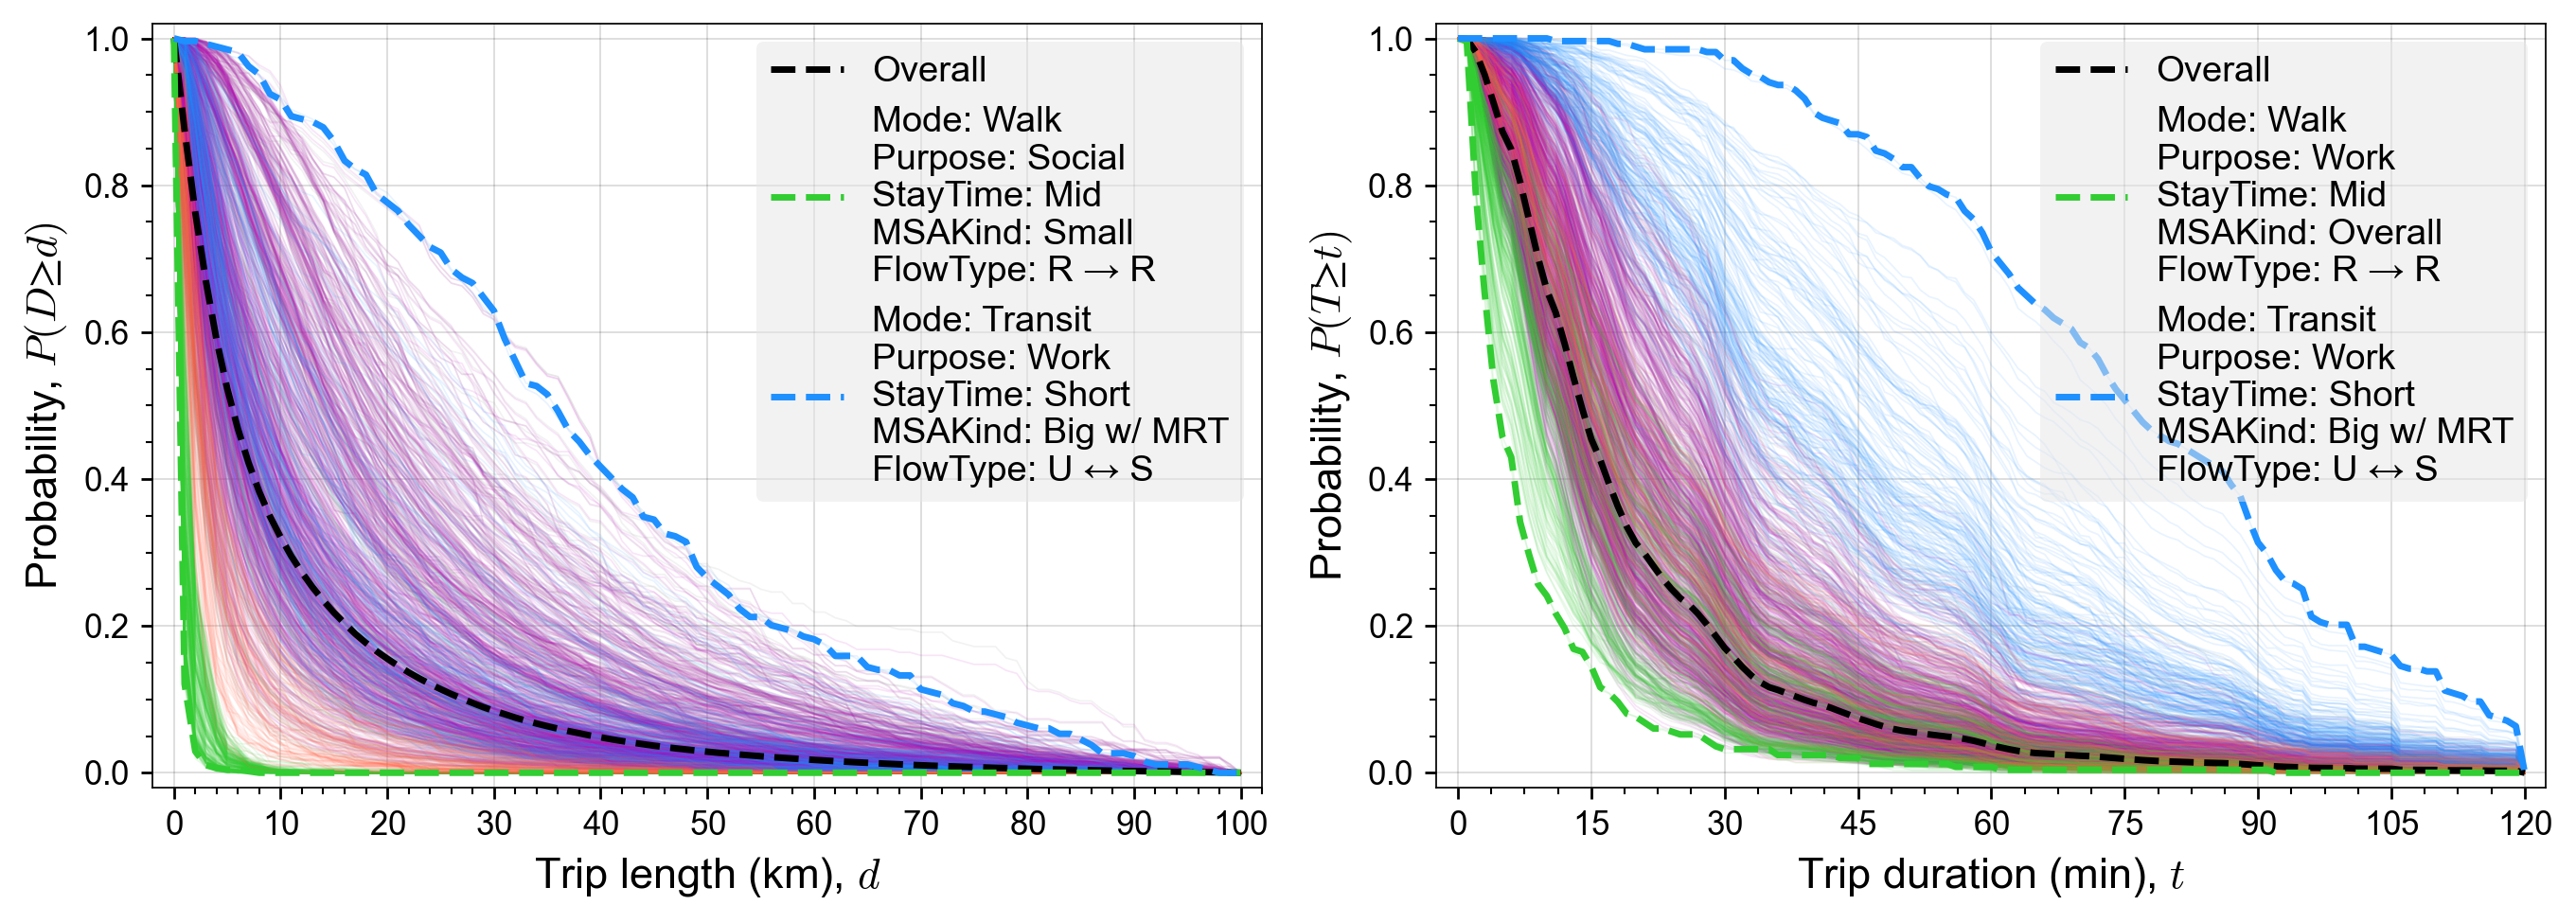

In [4]:
def fig_imped_curves(hists=hists, targets=(
        ('Distance', 10, 'd', 'Trip length (km)'),
        ('Duration', 15, 't', 'Trip duration (min)')),
                     pad=0.02, size=(11, 4), dpi=150, cmap='Set2'):
    factors = list(hists.select_dtypes(CAT).columns)[1:]
    mode_colors = D(Drive='m', Transit='dodgerblue', Walk='limegreen', Bike='tomato')
    _, axes = plt.subplots(1, 2, figsize=size, dpi=dpi)
    for i, (target, gap, s, label) in enumerate(targets):
        df = hists.query(f'Target=="{target}"')
        xmin, xmax, rng = df.x.min(), df.x.max(), df.x.max() - df.x.min()
        ax = pplot(axes[i], xlim=(xmin - pad * rng, xmax + pad * rng),
                   ylim=(0 - pad, 1 + pad), xlab='%s, $%s$' % (label, s),
                   ylab='Probability, $P(%s≥%s)$' % (s.upper(), s))
        for comb, d in df.groupby(factors):
            comb = D(zip(factors, comb))
            color = mode_colors.get(comb['Mode'], 'grey')
            ax.plot(d.x, d.y, lw=0.5, alpha=0.1, color=color)
        d = df.query(' & '.join([f'{x}=="Overall"' for x in factors]))
        ax.plot(d.x, d.y, lw=2, color='k', label='Overall', ls='--')
        idx = df.groupby(factors)['y'].mean().dropna().sort_values().index
        for j in [1, -1]:
            comb = D(zip(factors, idx[j]))
            d = df.query(' & '.join([f'{k}=="{v}"' for k, v in comb.items()]))
            label = '\n'.join([f'{k}: {v}' for k, v in comb.items()])
            color = mode_colors.get(comb['Mode'], 'k')
            ax.plot(d.x, d.y, lw=2, color=color, label=label, ls='--')
        ax.legend()
        ax.set_xticks(np.arange(xmin, xmax + 1e-5, gap))
    plt.tight_layout()

x = fig_imped_curves(dpi=250); x # t=0:12

## 3.2. Select the functional form

In [5]:
imped_funcs = {
    'Power': lambda x, a: x ** a,
    'Base exponential': lambda x, a: np.exp(a * x),
    'Sherratt Tanner': lambda x, a: np.exp(-a * (x ** 2)),
    'Logistic': lambda x, a: 2 * (1 + np.exp(a * x)) ** (-1),
    'Power exponential': lambda x, a, b: np.exp(-a * (x ** b)),
    'Tanner': lambda x, a, b: (x ** a) * np.exp(b * x),
    'Quadratic exponential': lambda x, a, b: np.exp(a * x - b * (x ** 2)),
    # 'Cubic exponential': lambda x, a, b, c: np.exp(-a * x + b * (x ** 2) - c * (x ** 3)),
}

In [6]:
def fit_decay_functions(funcs=imped_funcs, hists=hists, overwrite=False):
    outpath = Path('../data/decay_func_fit.parquet')
    if outpath.exists() and not overwrite:
        return pd.read_parquet(outpath)
    res = []
    factors = list(hists.select_dtypes(CAT).columns)[1:]
    for comb, df in tqdm(hists.groupby(['Target'] + factors)):
        comb = D(zip(['Target'] + factors, comb))
        x, y = df.x.values[1:], df.y.values[1:]
        for fname, func in funcs.items():
            try:
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    params = curve_fit(func, x, y)[0]
                    yfit = func(x, *params).clip(0, 1)
                r2 = r2_score(y, yfit)
                if r2 < 0 or r2 > 1: continue
            except RuntimeError as e:
                print('ERROR:', fname, comb, e)
                continue
            res.append(comb | D(Func=fname, R2=r2, Params=list(params)))
    df = Pdf(res)
    for col in factors:
        df[col] = ordered_factor(df[col])
    df.to_parquet(mkfile(outpath))
    return df

fitted = fit_decay_functions(overwrite=0).disp() # t=1:02
# x = fit_decay_functions(overwrite=1); x

22,421 rows x 9 cols; Memory: 5.7 MiB


,Target,Mode,Purpose,StayTime,MSAKind,FlowType,Func,R2,Params
,<object>,<category>,<category>,<category>,<category>,<category>,<object>,<float64>,<object>
0,Distance,Overall,Overall,Overall,Overall,Overall,Power,0.857631,[-0.6569246566069348]


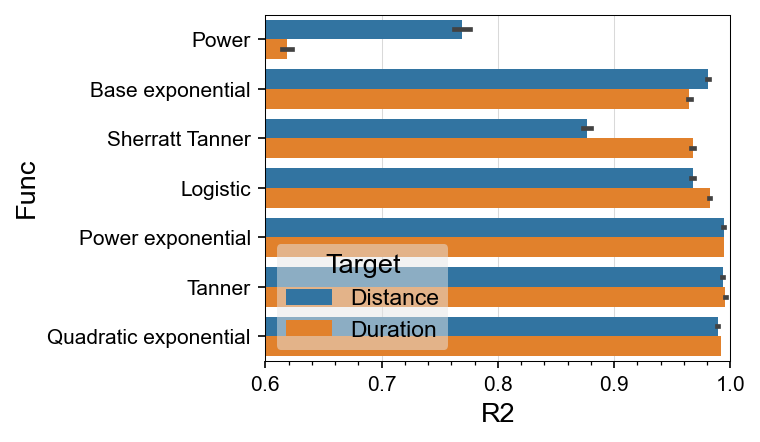

In [7]:
ax = pplot(size=(4, 3), dpi=150, yminor=0, xlim=(0.6, 1))
sns.barplot(fitted, y='Func', x='R2', hue='Target', ax=ax);

In [8]:
(fitted.groupby(['Func', 'Target'])['R2'].describe()
 .reset_index().rename(columns=str.title)
 .melt(['Func', 'Target']).assign(
     Statistic=lambda df: pd.Categorical(
         df.variable, categories=['Mean', 'Std', 'Min', 'Max']))
 .pivot_table('value', 'Func', ['Target', 'Statistic'])
 .loc[list(imped_funcs.keys())].reset_index())

Target                      Func  Distance                                \
Statistic                             Mean       Std       Min       Max   
0                          Power  0.769077  0.133331  0.031136  0.951156   
1               Base exponential  0.980781  0.017880  0.816478  0.999863   
2                Sherratt Tanner  0.876681  0.072757  0.492518  0.997021   
3                       Logistic  0.967386  0.030867  0.725267  0.999687   
4              Power exponential  0.994151  0.005268  0.949296  0.999927   
5                         Tanner  0.993343  0.008214  0.882186  0.999886   
6          Quadratic exponential  0.988943  0.013003  0.871857  0.999935   

Target     Duration                                
Statistic      Mean       Std       Min       Max  
0          0.618610  0.085773  0.301223  0.884773  
1          0.964800  0.027928  0.740602  0.998570  
2          0.967682  0.026687  0.818122  0.999375  
3          0.982011  0.016969  0.797916  0.998930  
4          0.994696  0.002968  0.979152  0.999463  
5          0.995655  0.004864  0.924272  0.999413  
6          0.991918  0.004127  0.973298  0.999536

## 3.3 Coefficients of single-factor scenarios

In [9]:
def table_single_factor_coef(fitted=fitted, trips=trips, funcs=(
        'Base exponential', 'Power exponential')):
    res = []
    fitted = fitted.pipe(lambda df: df[df.Func.isin(funcs)])
    factors = list(fitted.loc[:, 'Target': 'Func'].columns[1:-1])
    filt = (fitted.query(' & '.join([f'{x}=="Overall"' for x in factors]))
            .assign(Factor='Overall', Level=''))
    cats = [('Overall', '')]
    for col in factors:
        cats += [(col, x) for x in trips[col].cat.categories]
        df = fitted[fitted[col] != 'Overall'].rename(columns={col: 'Level'})
        df = df.query(' & '.join([f'{x}=="Overall"' for x in set(factors) - {col}]))
        filt = pd.concat([filt, df.assign(Factor=col)])
    df = filt[['Target', 'Factor', 'Level', 'Func', 'Params']].copy()
    df['Param'] = [[f'β{i + 1}' for i in range(len(x))] for x in df.Params]
    df = df.explode(['Param', 'Params']).reset_index(drop=1)
    neg_idx = df[(df.Func == 'Power exponential') & (df.Param == 'β1')].index
    df.loc[neg_idx, 'Params'] *= -1
    df = df.set_index(['Factor', 'Level']).loc[cats].reset_index()
    df.Factor, df.Level = ordered_factor(df.Factor), ordered_factor(df.Level)
    df = df.pivot_table('Params', ['Factor', 'Level'], ['Target', 'Func', 'Param'])
    return df.reset_index()

x = table_single_factor_coef(); x

Target    Factor        Level         Distance                              \
Func                          Base exponential Power exponential             
Param                                       β1                β1        β2   
0        Overall                     -0.104787         -0.186239  0.767961   
1           Mode        Drive        -0.094746         -0.146983  0.828589   
2           Mode      Transit        -0.070881         -0.095603  0.895006   
3           Mode         Walk        -1.073428         -1.166489  0.752766   
4           Mode         Bike        -0.278931         -0.331522  0.879662   
5        Purpose         Work        -0.061525         -0.074291  0.937713   
6        Purpose     Shopping         -0.14622          -0.22883  0.788063   
7        Purpose       Social        -0.116845         -0.191261  0.790999   
8        Purpose      Medical        -0.074765         -0.098277  0.902372   
9        Purpose   Recreation        -0.132565         -0.247675  0.720172   
10      StayTime        Short        -0.116964          -0.20954  0.753084   
11      StayTime          Mid        -0.098023         -0.161297  0.803932   
12      StayTime         Long        -0.050679         -0.039846  1.074891   
13       MSAKind   Big w/ MRT        -0.106588         -0.218732  0.709075   
14       MSAKind  Big w/o MRT        -0.098048         -0.160941  0.806035   
15       MSAKind        Small        -0.108152         -0.190987  0.766847   
16      FlowType        U → U        -0.222835         -0.372196  0.696887   
17      FlowType        S → S        -0.133169         -0.221594  0.770092   
18      FlowType        R → R        -0.100979         -0.200499  0.732449   
19      FlowType        U ↔ S        -0.085902         -0.094103  0.965215   
20      FlowType        S ↔ R         -0.04841         -0.029692  1.152621   
21      FlowType        R ↔ U        -0.038305         -0.015494  1.264775   

Target         Duration                              
Func   Base exponential Power exponential            
Param                β1                β1        β2  
0              -0.05334         -0.024008  1.260028  
1             -0.054185         -0.020852  1.313294  
2             -0.019796         -0.001313   1.67974  
3             -0.059438         -0.057189  1.012764  
4             -0.046071         -0.022802  1.218564  
5             -0.040804         -0.012484  1.353085  
6             -0.066226         -0.024446  1.351167  
7             -0.059225         -0.025138  1.289815  
8             -0.041333          -0.01152  1.385057  
9             -0.052314         -0.024566  1.245145  
10            -0.056586         -0.027287  1.242528  
11             -0.05049         -0.018748  1.317632  
12             -0.03717         -0.006732  1.496445  
13             -0.04702         -0.026089  1.183552  
14            -0.051177         -0.019954  1.301929  
15             -0.05655         -0.024774  1.274664  
16            -0.063165         -0.033939  1.214899  
17            -0.061799         -0.028032  1.270711  
18            -0.058714         -0.039895  1.128813  
19            -0.046967         -0.011134  1.454376  
20            -0.037429         -0.007339  1.478454  
21            -0.030263          -0.00406  1.558021

## 3.4 Reduce factor combinations

In [10]:
import shap
from xgboost import XGBRegressor

In [11]:
def compare_fit_coefs(fitted=fitted, func='Base exponential'):
    factors = list(fitted.loc[:, 'Target': 'Func'].columns[1:-1])
    res = []
    for target, df in fitted.query(f'Func=="{func}"').groupby('Target'):
        df = df.explode('Params')
        X, y = pd.get_dummies(df[factors], prefix_sep='__'), df.Params
        X = X.drop(columns=X.filter(like='__Overall').columns)
        model = XGBRegressor().fit(X, y)
        explainer = shap.TreeExplainer(model, seed=SEED)
        sh = Pdf(explainer(X).values, columns=X.columns).astype(np.float32)
        for col in factors:
            df = np.abs(sh.filter(like=col + '__'))
            df = df.mean().rename('SHAP')
            df = df.rename_axis('Level').reset_index()
            df.Level = [x.split('__')[1] for x in df.Level]
            res.append(df.assign(Target=target, Factor=col))
    df = pd.concat(res)
    return df

fit_coefs = compare_fit_coefs().disp()

[11:03:41] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


42 rows x 4 cols; Memory: 0.0 MiB


[11:03:41] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


,Level,SHAP,Target,Factor
,<object>,<float32>,<object>,<object>
0,Drive,0.004307,Distance,Mode


## Feature contribution

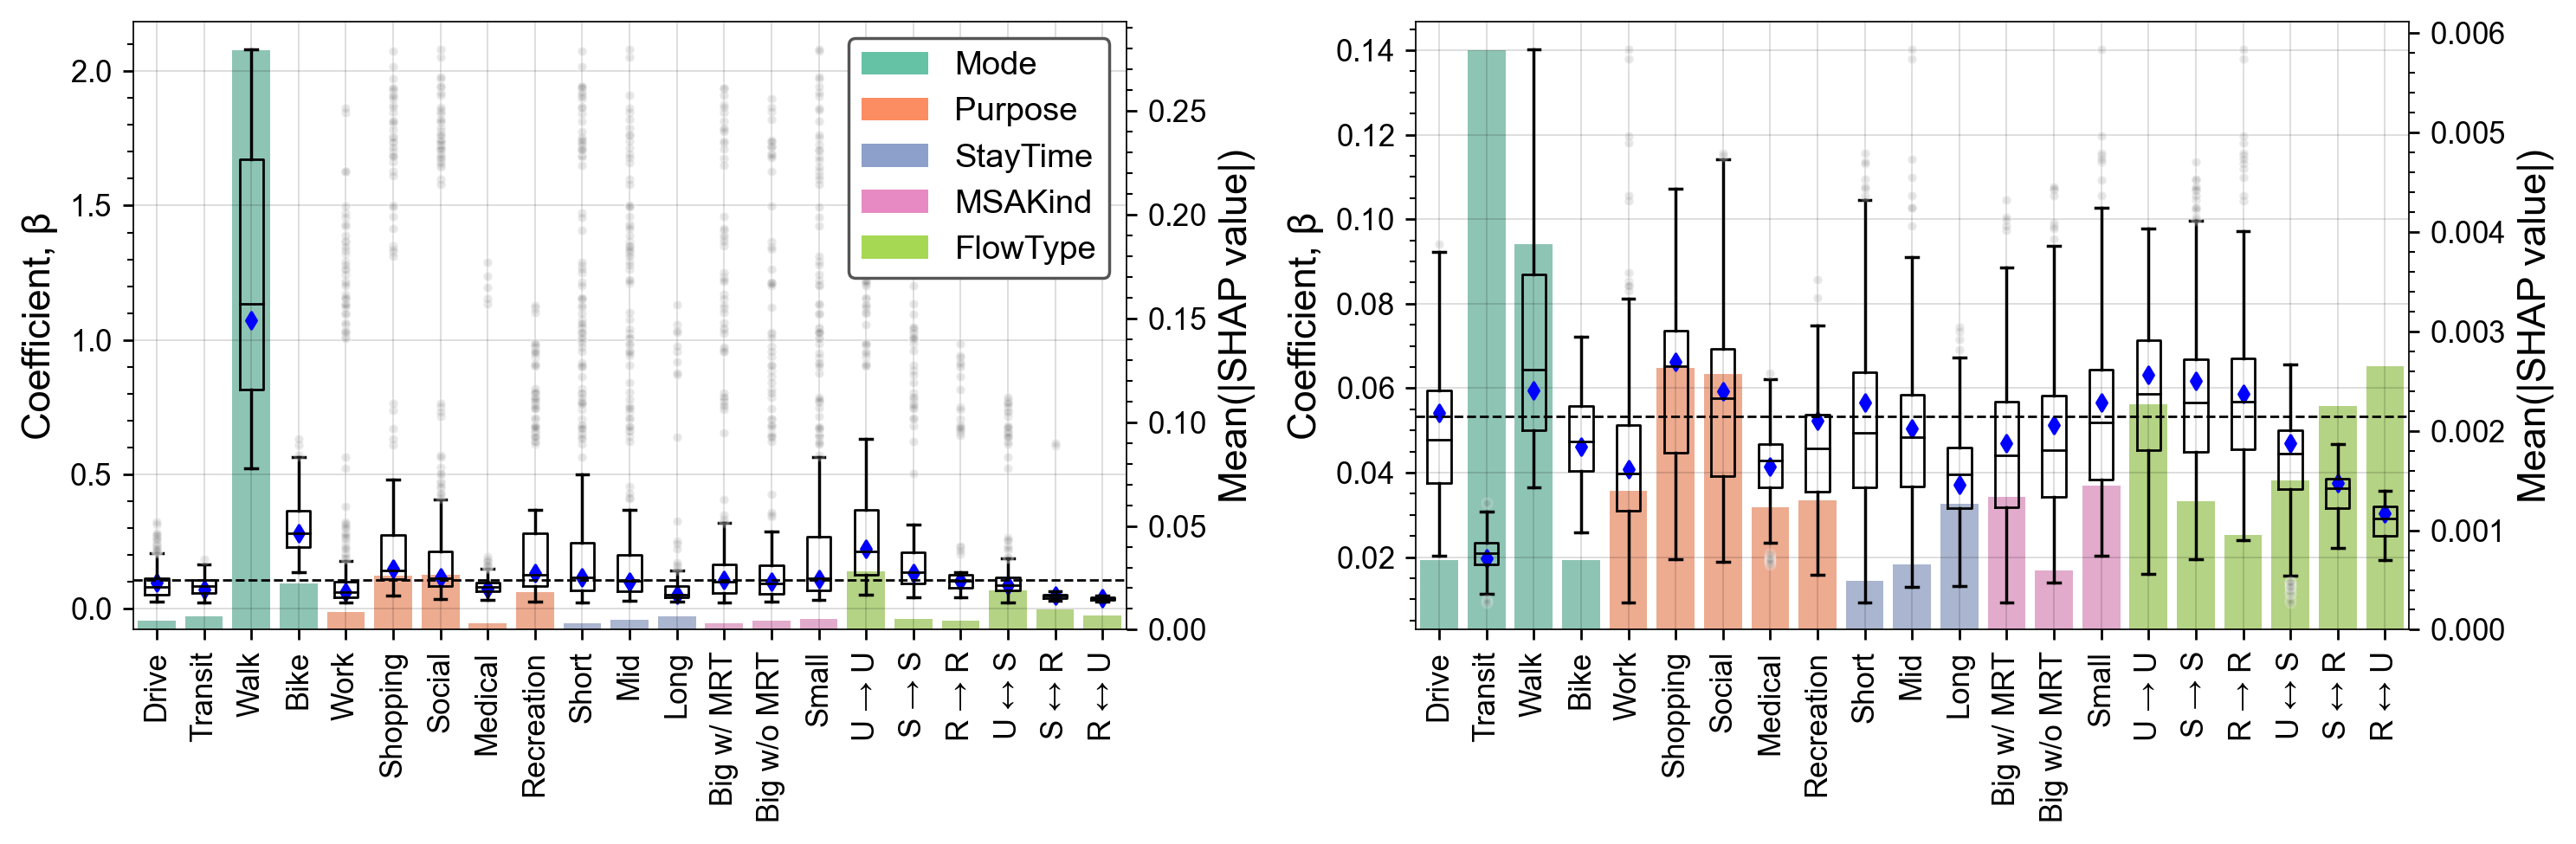

In [12]:
def fig_comb_curves(hists=hists, fitted=fitted, fit_coefs=fit_coefs,
                    targets=('Distance', 'Duration'),
                    pad=0.02, size=(12, 4), dpi=150, cmap='Set2'):
    factors = list(hists.select_dtypes(CAT).columns)[1:]
    mode_colors = D(Drive='m', Transit='dodgerblue', Walk='limegreen', Bike='tomato')
    _, axes = plt.subplots(1, 2, figsize=size, dpi=dpi)
    for i, target in enumerate(targets):
        df = fit_coefs.query(f'Target=="{target}"').reset_index(drop=1)
        pos = {x: i for i, x in df.Level.items()}
        ax = pplot(axes[i], xminor=0, ylab='Coefficient magnitude, |β|')
        twin = pplot(ax.twinx(), yminor=0, gridcolor='w')
        ax.set_zorder(1)
        ax.set_frame_on(False)
        sns.barplot(df, x='Level', y='SHAP', hue='Factor',
                    ax=twin, alpha=0.8, legend=False, palette=cmap)
        twin.set_ylabel('Mean(|SHAP value|)'); twin.set_xlabel('')
        xticks = list(zip(*df.Level.items()))
        twin.set_xticks(*xticks, rotation=90)
        df = fitted.query(f'Target=="{target}" & Func=="Base exponential"')
        df = df.drop(columns=['Target', 'Func', 'R2']).explode('Params')
        df = df.rename(columns=D(Params='Coef')).astype(D(Coef=np.float32))
        df.Coef *= -1
        coefs = sum([[d.Coef for level, d in df.groupby(col)
                      if level != 'Overall'] for col in factors], [])
        ax.boxplot(coefs, positions=xticks[0], boxprops=D(lw=0.8),
                   flierprops=D(markersize=3, linewidth=0, alpha=0.2,
                                markeredgecolor='w', markerfacecolor='grey'),
                   medianprops=D(color='k', lw=0.8))
        overall = df.query(' & '.join([f'{x}=="Overall"' for x in factors]))
        for col in factors:
            others = [f'{x}=="Overall"' for x in set(factors) - {col}]
            for _, r in df.query(' & '.join(others)).iterrows():
                if r[col] == 'Overall': continue
                ax.scatter(pos[r[col]], r.Coef, marker='d', c='b', s=15)
        ax.axhline(overall.iloc[0].Coef, ls='--', lw=0.8, color='k')
        ax.set_xticks(*xticks, rotation=90)
        col_colors = D(zip(factors, sns.color_palette(cmap, len(factors))))
        if i == 0:
            ax.legend(handles=[mpl.patches.Patch(
                fc=color, ec='none', label=col, alpha=1)
                               for col, color in col_colors.items()],
                      loc=1, framealpha=1, facecolor='w', edgecolor='#555')
    plt.tight_layout()

x = fig_comb_curves(dpi=250); x